In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
from statsmodels.stats.moment_helpers import cov2corr
np.random.seed(5000)

In [2]:
def plot(df):
    fig = plt.figure(figsize=(8, 2))
    ax = fig.add_subplot(1, 2, 1)
    df.iloc[:5].plot(ax=ax)
    ax = fig.add_subplot(1, 2, 2)
    df.plot(ax=ax)
    print("First values of y: {}".format(df.iloc[:5, 0].values))
    if "y2" in df.columns:
        print("First values of y2: {}".format(df.iloc[:5, 1].values))
    return fig, ax

def plot_wrapper(params, mod, initial_state):
    df = pd.DataFrame(mod.simulate(params=params, nsimulations=300, initial_state=initial_state))
    fig, ax = plot(df)
    return fig, ax, df

# Time series - simulating known processes

Notes:
 - *endog* defines the time units used; it is important to explicitly do this, otherwise trend components are not treated corerctly
 - Notice required trend offset when we begin at $y_0 = 0$!
 - Seems that simulating twice from same mod results in weird behavior.

Links:

 - [statsmodels.tsa.statespace.structural.UnobservedComponents](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
 - [statsmodels.tsa.statespace.structural.UnobservedComponents.simulate](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.simulate.html#statsmodels.tsa.statespace.structural.UnobservedComponents.simulate)
 - [statespace.varmax](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html) and [statespace.varmax.simulate](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.simulate.html)
 - [Estimating or specifying parameters in state space models](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_fixed_params.html)

## Univariate

Some are done under *statespace.varmax* class for easier generalization to multivariate case. We could also use univariate classes like *ar_model.AR*.

$y_t = ct$

$t \geq 1$, with $y_0 = 0$, and $c=1$.

$
\begin{align*}
y_1 & = 1*1 = 1 \\
y_2 & = 1*2 = 2 \\
y_3 & = 1*3 = 3 \\
y_4 & = 1*4 = 4 \\
\dots
\end{align*}
$

drift.y :1
L1.y.y :0
sqrt.var.y :0
First values of y: [0. 1. 2. 3. 4.]


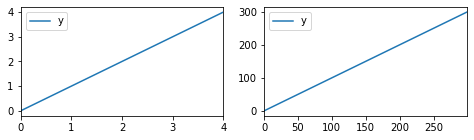

In [3]:
initial_state = 0
params = [1, 0, 0]

endog = pd.DataFrame({"y":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="t", trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

$y_t = ct + y_{t-1}$

$t \geq 1$, with $y_0 = 1$, and $c=1$.

$
\begin{align*}
y_1 & = 1*1 + 1 = 2 \\
y_2 & = 1*2 + 2 = 4 \\
y_3 & = 1*3 + 4 = 7 \\
y_4 & = 1*4 + 7 = 11 \\
\dots
\end{align*}
$

drift.y :1
L1.y.y :1
sqrt.var.y :0
First values of y: [ 1.  2.  4.  7. 11.]


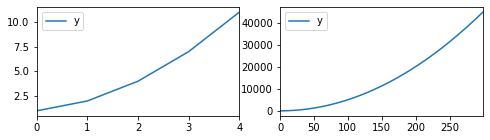

In [4]:
initial_state = 1
params = [1, 1, 0]

endog = pd.DataFrame({"y":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="t", trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

$y_t = \gamma + ct + y_{t-1}$

$t \geq 1$, with $y_0 = 1$, $\gamma = 2$, and $c=1$.

$
\begin{align*}
y_1 & = 2 + 1*1 + 1 = 4 \\
y_2 & = 2 + 1*2 + 4 = 8 \\
y_3 & = 2 + 1*3 + 8 = 13 \\
y_4 & = 2 + 1*4 + 13 = 19 \\
\dots
\end{align*}
$

intercept.y :2
drift.y :1
L1.y.y :1
sqrt.var.y :0
First values of y: [ 1.  4.  8. 13. 19.]


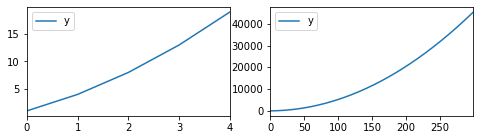

In [5]:
initial_state = 1
params = [2, 1, 1, 0]

endog = pd.DataFrame({"y":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend=[1, 1], trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

Random walk

$
\begin{align*}
y_t & = \mu_t \\
\mu_t & = \mu_{t-1} + \eta_t \\
\end{align*}
$

sigma2.level :1
First values of y: [1.         0.92707134 2.92579493 2.89328216 2.15676627]


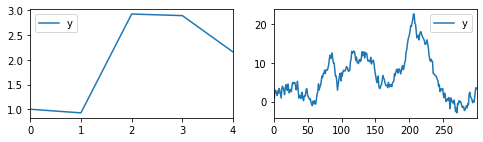

In [6]:
initial_state = 1
params = [1]

endog = pd.DataFrame({"y":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.UnobservedComponents(endog, level="rwalk")
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

## Multivariate

Correlated random walk

$y_t = y_{t-1} + e_t$ with $t \geq 1$ and $y_0 = 1$,

$
\begin{align*}
y_t = \begin{bmatrix} y_{1,t} \\  y_{2,t} \end{bmatrix}
\end{align*}
$,
$
\begin{align*}
e_t = \begin{bmatrix} \epsilon_{1,t} \\  \epsilon_{2,t} \end{bmatrix}
\end{align*}
$

Errors $\epsilon_{1,t}, \epsilon_{2,t}$ follow multivariate normal dsitribution with covariance matrix

$
\begin{align*}
e_t = \begin{bmatrix} 1 & 0.8 \\ 0.8 &  1 \end{bmatrix}
\end{align*}
$

L1.y.y :1
L1.y2.y :0
L1.y.y2 :0
L1.y2.y2 :1
sqrt.var.y :1.0
sqrt.cov.y.y2 :0.8944271909999159
sqrt.var.y2 :1.0
First values of y: [ 0.         -0.33115315 -1.04560798 -1.44139492 -1.11905894]
First values of y2: [ 0.         -1.36034242 -1.13554671 -1.5219945  -1.45717657]


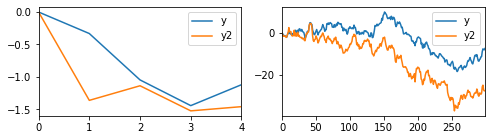

In [7]:
initial_state = [0, 0]
params = [1, 0, 0, 1, np.sqrt(1), np.sqrt(0.8), np.sqrt(1)]

endog = pd.DataFrame({"y":[np.nan, np.nan], "y2":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="n", trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

Correlated random walk with drift

$y_t = ct + y_{t-1} + e_t$ with $t \geq 1$ and $y_0 = 1$,

$
\begin{align*}
y_t = \begin{bmatrix} y_{1,t} \\  y_{2,t} \end{bmatrix}
\end{align*}
$,
$
\begin{align*}
e_t = \begin{bmatrix} \epsilon_{1,t} \\  \epsilon_{2,t} \end{bmatrix}
\end{align*}
$,
$
\begin{align*}
c = \begin{bmatrix} 0.2 \\  0.1 \end{bmatrix}
\end{align*}
$

Errors $\epsilon_{1,t}, \epsilon_{2,t}$ follow multivariate normal dsitribution with correlation 0.8 and standard deviations 300 and 500, espectively.

drift.y :0.2
drift.y2 :0.1
L1.y.y :1
L1.y2.y :0
L1.y.y2 :0
L1.y2.y2 :1
sqrt.var.y :300
sqrt.cov.y.y2 :268.32815729997475
sqrt.var.y2 :500
First values of y: [   0.         -517.28076588 -367.86186168 -242.56139977 -275.05142218]
First values of y2: [   0.         -253.22485998  -13.90348588  224.79638613  321.83970253]


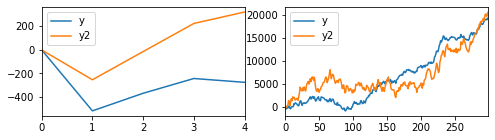

In [8]:
initial_state = [0, 0]
params = [0.2, 0.1, 1, 0, 0, 1, 300, np.sqrt(0.8*300*300), 500]

endog = pd.DataFrame({"y":[np.nan, np.nan], "y2":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="t", trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

Deterministic processes with drift and intercept

$y_t = \gamma + ct $ with $t \geq 1$ and $y_0 = 1$,

$
\begin{align*}
y_t = \begin{bmatrix} y_{1,t} \\  y_{2,t} \end{bmatrix}
\end{align*}
$,
$
\begin{align*}
\gamma = \begin{bmatrix} 2 \\  1 \end{bmatrix}
\end{align*}
$,
$
\begin{align*}
c = \begin{bmatrix} 0.2 \\  0.1 \end{bmatrix}
\end{align*}
$

BUG in param_names ordering of intercepts and drifts!

intercept.y :2
intercept.y2 :0.2
drift.y :1
drift.y2 :0.1
L1.y.y :0
L1.y2.y :0
L1.y.y2 :0
L1.y2.y2 :0
sqrt.var.y :0
sqrt.cov.y.y2 :0
sqrt.var.y2 :0
First values of y: [0.  2.2 2.4 2.6 2.8]
First values of y2: [0.  1.1 1.2 1.3 1.4]


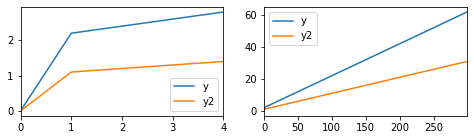

In [9]:
endog = pd.DataFrame({"y":[np.nan, np.nan], "y2":[np.nan, np.nan]}, index=[0, 1])
params = [2, 0.2, 1, 0.1, 0, 0, 0, 0, 0, 0, 0]

mod = sm.tsa.VARMAX(endog, order=(1, 0), trend=[1, 1], trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state)

Correct from here below!!!

Vanilla vector auto-regression VAR(1)

$
\begin{align*}
Y_{1,t} & = \beta_{1,0} + \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{2,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,0} + \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1} + \epsilon_{2,t} \\
\end{align*}
$

with coefficient matrix

$
\begin{align*}
\mathbf{B} = \begin{bmatrix} \beta_{1,0} & \beta_{1,1} & \beta_{1,2} \\ \beta_{2,0} & \beta_{2,1} & \beta_{2,2} \end{bmatrix} =
\begin{bmatrix} 0 & 0.8 & 0.5 \\ 3 & -0.2 & 0.1 \end{bmatrix}
\end{align*}
$

Errors $\epsilon_{1,t}, \epsilon_{2,t}$ follow multivariate normal dsitribution with covariance matrix

$
\begin{align*}
\mathbf{\Sigma} = \begin{bmatrix} 1 & 0.4 \\ 0.4 & 1 \end{bmatrix} ,
\end{align*}
$

meaning that $Corr(\epsilon_{1,t}, \epsilon_{2,t}) = 0.2$.

intercept.y :0.0
intercept.y2 :3.0
L1.y.y :0.8
L1.y2.y :0.5
L1.y.y2 :-0.2
L1.y2.y2 :0.1
sqrt.var.y :1.0
sqrt.cov.y.y2 :0.2
sqrt.var.y2 :1.0
First values of y: [0.         1.95514756 3.12183968 2.89084412 4.40717772]
First values of y2: [3.         3.20503076 2.18518459 2.21615341 2.84046238]


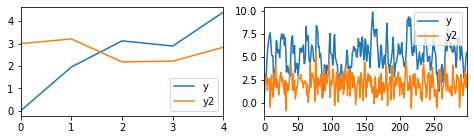

In [10]:
intercepts = np.array(
    [0, 3], #beta_01, beta_02
)
coefs = np.array([
       [0.8, 0.5], # beta_11, beta_12, 
       [-0.2, 0.1], # beta_21, beta_22
]).flatten(order="C")
corr = np.array([
    [1, 0.2],
    [0.2, 1],
])
stds = [1, 1] # std(e_1t), std(e_2t)
cov = corr2cov(corr, stds)

#endog = np.array([[ None,  None]])
endog = pd.DataFrame({"y":[np.nan, np.nan], "y2":[np.nan, np.nan]}, index=[0, 1])

mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="c")
params = np.concatenate([intercepts, coefs, cov[np.triu_indices(cov.shape[1])]], axis=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state=intercepts)

Vector auto-regression VAR(1) with drift

$
\begin{align*}
Y_{1,t} & = \beta_{1,0} + c_1 t + \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{2,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,0} + c_2 t + \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1} + \epsilon_{2,t} \\
\end{align*}
$,

$
\begin{align*}
\mathbf{B} = \begin{bmatrix} \beta_{1,0} & \beta_{1,1} & \beta_{1,2} \\ \beta_{2,0} & \beta_{2,1} & \beta_{2,2} \end{bmatrix} =
\begin{bmatrix} 0 & 0.8 & 0.5 \\ 3 & -0.2 & 0.1 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
c = \begin{bmatrix} 2 \\ 3 \end{bmatrix}
\end{align*}
$


Errors $\epsilon_{1,t}, \epsilon_{2,t}$ follow multivariate normal dsitribution with covariance matrix

$
\begin{align*}
\mathbf{\Sigma} = \begin{bmatrix} 1 & 0.4 \\ 0.4 & 1 \end{bmatrix} ,
\end{align*}
$

meaning that $Corr(\epsilon_{1,t}, \epsilon_{2,t}) = 0.2$.

BUG in the orrderig of drifts and intercetps in param_names!

intercept.y :0.0
intercept.y2 :0.002
drift.y :3.0
drift.y2 :0.003
L1.y.y :0.8
L1.y2.y :0.5
L1.y.y2 :-0.3
L1.y2.y2 :0.2
sqrt.var.y :1.0
sqrt.cov.y.y2 :0.4
sqrt.var.y2 :1.0
First values of y: [ 0.         -1.15745093 -1.03334176  0.75048754  3.63543103]
First values of y2: [0.         2.43783362 3.88871024 3.5494108  6.00280331]


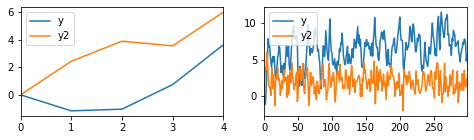

In [11]:
intercepts = np.array(
    [0, 0.002], #beta_1, c_1
)
drifts = np.array(
    [3, 0.003], #beta_2, c_2
)
coefs = np.array([
       [0.8, 0.5], # beta_11, beta_12, 
       [-0.3, 0.2], # beta_21, beta_22
]).flatten(order="C")
corr = np.array([
    [1, 0.4],
    [0.4, 1],
])
stds = [1, 1] # std(e_1t), std(e_2t)
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y":[0, 0], "y2":[0, 0]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend=[1, 1], trend_offset=0)
params = list(np.concatenate([intercepts, drifts, coefs, cov[np.triu_indices(cov.shape[1])]], axis=0))
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

fig, ax, df = plot_wrapper(params, mod, initial_state=[0, 0])

# Time series - Estimate SVAR

[statsmodels.tsa.vector_ar.svar_model.SVAR](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.svar_model.SVAR.html)<br>
[statsmodels.tsa.vector_ar.svar_model.SVAR.fit](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.svar_model.SVAR.fit.html#statsmodels.tsa.vector_ar.svar_model.SVAR.fit)<br>
[statsmodels.tsa.vector_ar.svar_model.SVARResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.svar_model.SVARResults.html#statsmodels.tsa.vector_ar.svar_model.SVARResults)

From Lütkepohl & Killian (2017) p. 217:
Reduced-form VAR is given by

$
\begin{align*}
y_t & = A_1 y_{t-1} + \cdots + A_p y_{t-p} + u_{t}
\end{align*}
$.

If  $u_{t} = B_0^{-1} w_t$, then 

$
\begin{align*}
y_t & = A_1 y_{t-1} + \cdots + A_p y_{t-p} + B_0^{-1} w_t \\
\end{align*}
$

Pre-multiply by $B_0$

$
\begin{align*}
B_0 y_t & = B_0 A_1 y_{t-1} + \cdots + B_0 A_p y_{t-p} +  w_t \\
\end{align*}
$

and define $B_i \equiv B_0 A_i$ to obtain SVAR representation

$
\begin{align*}
B_0 y_t & = B_1 y_{t-1} + \cdots + B_p y_{t-p} +  w_t \\
\end{align*}
$

In statsmodels documentation, with redefining symbols a bit, we have so-called the "AB-model" (or here "DE"-model)

$
\begin{align*}
D y_t & = A_1 y_{t-1} + \cdots + A_p y_{t-p} + E w_{t}
\end{align*}
$

corresponds to above case when $E = \mathbf{I}$ and $B_0 = D$.

Take example from ts_causality_1.ipynb...
